# FP-Growth

In [28]:
def transfer2FrozenDataSet(dataSet):
    frozenDataSet = {}
    for elem in dataSet:
        frozenDataSet[frozenset(elem)] = 1
    return frozenDataSet

class TreeNode:
    def __init__(self, nodeName, count, nodeParent):
        self.nodeName = nodeName
        self.count = count
        self.nodeParent = nodeParent
        self.nextSimilarItem = None
        self.children = {}

    def increaseC(self, count):
        self.count += count

def createFPTree(frozenDataSet, minSupport):
    #scan dataset at the first time, filter out items which are less than minSupport
    headPointTable = {}
    for items in frozenDataSet:
        for item in items:
            headPointTable[item] = headPointTable.get(item, 0) + frozenDataSet[items]
    headPointTable = {k:v for k,v in headPointTable.items() if v >= minSupport}
    frequentItems = set(headPointTable.keys())
    if len(frequentItems) == 0: return None, None

    for k in headPointTable:
        headPointTable[k] = [headPointTable[k], None]
    fptree = TreeNode("null", 1, None)
    #scan dataset at the second time, filter out items for each record
    for items,count in frozenDataSet.items():
        frequentItemsInRecord = {}
        for item in items:
            if item in frequentItems:
                frequentItemsInRecord[item] = headPointTable[item][0]
        if len(frequentItemsInRecord) > 0:
            orderedFrequentItems = [v[0] for v in sorted(frequentItemsInRecord.items(), key=lambda v:v[1], reverse = True)]
            updateFPTree(fptree, orderedFrequentItems, headPointTable, count)

    return fptree, headPointTable

def updateFPTree(fptree, orderedFrequentItems, headPointTable, count):
    #handle the first item
    if orderedFrequentItems[0] in fptree.children:
        fptree.children[orderedFrequentItems[0]].increaseC(count)
    else:
        fptree.children[orderedFrequentItems[0]] = TreeNode(orderedFrequentItems[0], count, fptree)

        #update headPointTable
        if headPointTable[orderedFrequentItems[0]][1] == None:
            headPointTable[orderedFrequentItems[0]][1] = fptree.children[orderedFrequentItems[0]]
        else:
            updateHeadPointTable(headPointTable[orderedFrequentItems[0]][1], fptree.children[orderedFrequentItems[0]])
    #handle other items except the first item
    if(len(orderedFrequentItems) > 1):
        updateFPTree(fptree.children[orderedFrequentItems[0]], orderedFrequentItems[1::], headPointTable, count)

def updateHeadPointTable(headPointBeginNode, targetNode):
    while(headPointBeginNode.nextSimilarItem != None):
        headPointBeginNode = headPointBeginNode.nextSimilarItem
    headPointBeginNode.nextSimilarItem = targetNode

def mineFPTree(headPointTable, prefix, frequentPatterns, minSupport):
    #for each item in headPointTable, find conditional prefix path, create conditional fptree, then iterate until there is only one element in conditional fptree
    headPointItems = [v[0] for v in sorted(headPointTable.items(), key = lambda v:v[1][0])]
    if(len(headPointItems) == 0): return

    for headPointItem in headPointItems:
        newPrefix = prefix.copy()
        newPrefix.add(headPointItem)
        support = headPointTable[headPointItem][0]
        frequentPatterns[frozenset(newPrefix)] = support

        prefixPath = getPrefixPath(headPointTable, headPointItem)
        if(prefixPath != {}):
            conditionalFPtree, conditionalHeadPointTable = createFPTree(prefixPath, minSupport)
            if conditionalHeadPointTable != None:
                mineFPTree(conditionalHeadPointTable, newPrefix, frequentPatterns, minSupport)

def getPrefixPath(headPointTable, headPointItem):
    prefixPath = {}
    beginNode = headPointTable[headPointItem][1]
    prefixs = ascendTree(beginNode)
    if((prefixs != [])):
        prefixPath[frozenset(prefixs)] = beginNode.count

    while(beginNode.nextSimilarItem != None):
        beginNode = beginNode.nextSimilarItem
        prefixs = ascendTree(beginNode)
        if (prefixs != []):
            prefixPath[frozenset(prefixs)] = beginNode.count
    return prefixPath

def ascendTree(treeNode):
    prefixs = []
    while((treeNode.nodeParent != None) and (treeNode.nodeParent.nodeName != 'null')):
        treeNode = treeNode.nodeParent
        prefixs.append(treeNode.nodeName)
    return prefixs

def rulesGenerator(frequentPatterns, minConf, rules):
    for frequentset in frequentPatterns:
        if(len(frequentset) > 1):
            getRules(frequentset,frequentset, rules, frequentPatterns, minConf)

def removeStr(set, str):
    tempSet = []
    for elem in set:
        if(elem != str):
            tempSet.append(elem)
    tempFrozenSet = frozenset(tempSet)
    return tempFrozenSet


def getRules(frequentset,currentset, rules, frequentPatterns, minConf):
    for frequentElem in currentset:
        subSet = removeStr(currentset, frequentElem)
        confidence = frequentPatterns[frequentset] / frequentPatterns[subSet]
        if (confidence >= minConf):
            flag = False
            for rule in rules:
                if(rule[0] == subSet and rule[1] == frequentset - subSet):
                    flag = True
            if(flag == False):
                rules.append((subSet, frequentset - subSet, confidence))

            if(len(subSet) >= 2):
                getRules(frequentset, subSet, rules, frequentPatterns, minConf)

def fpGrowth(dataSet, minSupport):
#     dataSet = pluno_merge
    frozenDataSet = transfer2FrozenDataSet(dataSet)
#     minSupport = 32
    fptree, headPointTable = createFPTree(frozenDataSet, minSupport)
    # fptree.disp()
    frequentPatterns = {}
    prefix = set([])
    mineFPTree(headPointTable, prefix, frequentPatterns, minSupport)
    print("frequent patterns:")
    for item in frequentPatterns:
        print(item, frequentPatterns[item])
    minConf = 0.6
    rules = []
#     rulesGenerator(frequentPatterns, minConf, rules)
#     print("association rules:")
#     for item in rules:
#         print(item)

# Load Data

In [2]:
import numpy as np
import pandas as pd
with open('./trade_new.csv', 'r') as resourse_data:
    data = pd.read_csv(resourse_data)[['vipno', 'sldatime', 'pluno', 'dptno', 'bndno']]
data['sldatime'] = pd.to_datetime(data['sldatime'])
sort_data = data.sort_values(['sldatime'],ascending=True).groupby('vipno')
# print([x for x in sort_data])

[(781924,         vipno            sldatime     pluno  dptno    bndno
16474  781924 2016-04-04 19:12:24  14402009  14402  14350.0
18227  781924 2016-04-04 19:12:24  11533012  11533      NaN
11173  781924 2016-04-04 19:12:24  11532011  11532  11129.0
17419  781924 2016-04-04 19:12:24  15200007  15200  15094.0
3100   781924 2016-04-04 19:12:24  11531020  11531  11149.0
21734  781924 2016-04-04 19:12:24  10130009  10130  10106.0
6822   781924 2016-04-04 19:12:24  14050019  14050  14082.0
3491   781924 2016-04-04 19:12:24  14014034  14014  14759.0
18229  781924 2016-05-01 13:48:21  11533012  11533      NaN
18230  781924 2016-05-01 13:48:21  11533012  11533      NaN
17456  781924 2016-05-01 13:48:21  15200007  15200  15094.0
22051  781924 2016-05-01 13:48:21  14403083  14403      NaN
3174   781924 2016-05-01 13:48:21  10113009  10113  10706.0
17377  781924 2016-06-01 21:12:26  15200007  15200  15094.0
10512  781924 2016-06-01 21:12:26  15202012  15202  15052.0
20829  781924 2016-06-01 21:12

#### ii.	若把每个用户的交易记录合并，这样一个用户只存在一个（合并后的）交易记录，然后再重复a)中的步骤，其中要求support为2，4，6，8，10等共计6个阈值

### trade_new.csv

In [10]:
pluno_merge = [];
dptno_merge = [];
bndno_merge = [];
for x in sort_data:
    plu_temp = list(x[1]['pluno'].head(int(len(x[1])*0.6)))  
    pluno_merge.append(plu_temp)
    dpt_temp = list(x[1]['dptno'].head(int(len(x[1])*0.6))) 
    dptno_merge.append(dpt_temp)
    bnd_temp = list(x[1]['bndno'].head(int(len(x[1])*0.6)).dropna().astype(int))
    bndno_merge.append(bnd_temp)

In [5]:
support = [2, 4, 6, 8, 10]

In [6]:
import matplotlib.pyplot as plt
import time
pluno_runtime = []
dptno_runtime = []
bndno_runtime = []

In [7]:
import matplotlib.pyplot as plt

In [8]:
def get_runtime(support, data):
    temp = []
    for i in support:
        start = time.clock()
        fpGrowth(data, i)
        end = time.clock()
        temp.append(end - start)
    return temp
    
def time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, y):
    n_groups = len(support)

    fig, ax = plt.subplots()    
    index = np.arange(n_groups)    
    bar_width = 0.3  
         
    opacity = 0.4    
    rects1 = plt.bar(index, pluno_runtime, bar_width,alpha=opacity, color='k',label='pluno')    
    rects2 = plt.bar(index + bar_width, dptno_runtime, bar_width,alpha=opacity,color='b',label='dptno')    
    rects2 = plt.bar(index + bar_width * 2, bndno_runtime, bar_width,alpha=opacity,color='c',label='bndno')    

    plt.xlabel('Support')    
    plt.ylabel('Time')    
    plt.title('Time by support and itemno')    
    plt.xticks(index + bar_width, support)    
    plt.ylim(0, y);    
    plt.legend();    
      
    plt.tight_layout();   
    plt.show();

In [12]:
pluno_runtime = get_runtime(support, pluno_merge)

In [13]:
dptno_runtime = get_runtime(support, dptno_merge)

In [14]:
bndno_runtime = get_runtime(support, bndno_merge)

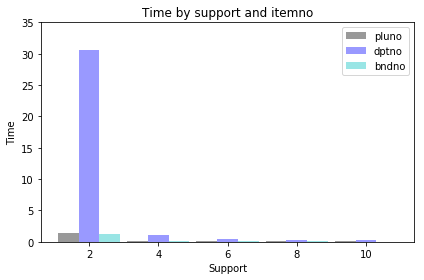

In [17]:
time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, 35)

### trade.csv

In [35]:
with open('./trade.csv', 'r') as resourse_data2:
    data2 = pd.read_csv(resourse_data2)[['vipno', 'sldat', 'pluno', 'dptno', 'bndno']]
data2['sldat'] = pd.to_datetime(data2['sldat'])
sort_data2 = data2.sort_values(['sldat'],ascending=True).groupby('vipno')
pluno_merge2 = [];
dptno_merge2 = [];
bndno_merge2 = [];
for x in sort_data2:
    plu_temp2 = list(x[1]['pluno'].head(int(len(x[1])*0.6)))  
    pluno_merge2.append(plu_temp2)
    dpt_temp2 = list(x[1]['dptno'].head(int(len(x[1])*0.6))) 
    dptno_merge2.append(dpt_temp2)
    bnd_temp2 = list(x[1]['bndno'].head(int(len(x[1])*0.6)).dropna().astype(int))
    bndno_merge2.append(bnd_temp2)

In [36]:
pluno_runtime2 = get_runtime(support, pluno_merge2)

In [37]:
dptno_runtime2 = get_runtime(support, dptno_merge2)

In [38]:
bndno_runtime2 = get_runtime(support, bndno_merge2)

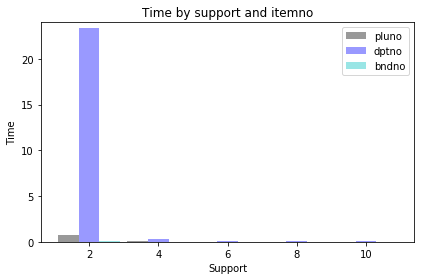

In [40]:
time_table(support, pluno_runtime2, dptno_runtime2, bndno_runtime2, 24)